In [1]:
from models import FeedforwardNeuralNetModel, TinyCNN, PatternClassifier
import regularizer_losts as rl
from torchvision import datasets, transforms
from torch import optim
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import copy
import utils as CFI_utils
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

import seaborn as sns
colors = sns.color_palette("tab10")

#Logging stuffs
import logging
import sys
# Create logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Set STDERR handler as the only handler 
logger.handlers = [handler]


#configs
epochs = 3
batch_size = 128
test_batch_size = 10000
use_cuda = True
lr = 1
log_interval = 100
LOAD = True
LOADPATH = 'TinyCNN15:36:27'

#torch specific configs
torch.manual_seed(1)

device = torch.device("cuda")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Agenda
### Big question: CFI for NN

### Backlog RQs: 
- BRQ1: Can we look at a random k entries in the weight instead of the first k?
- BRQ2: What if we set all the small abs weight in the Pattern classifer to 0? what is the accuracy in that case?
- BRQ3: Given an image and an l2-ball surrounding it, how many activation maps are there? (closely related to RQ1)
- BRQ4: Given a simple attacking method (e.g, Fast gradient sign), build a dataset of activation maps of true and fake digits. Try to train a pattern classifier using that dataset.

In [2]:
#init stuffs
dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

# model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
model = TinyCNN().to(device)


In [3]:
# try out cosine similarity
# input1 = torch.randn(1,128)
# input2 = torch.randn(1,128)
# print(input1)
# cos = torch.nn.CosineSimilarity(eps=1e-6)
# output = torch.nn.functional.cosine_similarity(input1.squeeze(), input2.squeeze(), dim=0)
# print(output)

## RQ3: Would regularization results in a bigger number of path overlapping?

In [15]:
#training loop
model = TinyCNN().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma = 0.7)
model.train()
# layers = ['conv1', 'conv2', 'fc1', 'fc2']
# layers = ['fc1', 'fc2']
layers = ['conv2','fc1', 'fc2']

MAX_BATCH = 999999
ALPHA = 0.01
BETA = 0.1 
for e in range(epochs):
    counter = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        for data, target in tepoch:
            if counter > MAX_BATCH:
                break
            counter+=1
            model.register_log(detach=False)
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data.float())    

            classification_loss = F.nll_loss(output, target)
            l1_loss = rl.l1(model)
            batch_activation_loss = rl.batch_activation_diff(model.tensor_log, target, layers)

            loss = classification_loss \
                    + ALPHA*l1_loss \
                    + BETA*batch_activation_loss
            
            tepoch.set_postfix({"classification_loss": classification_loss.data, 
                                "l1_loss": l1_loss.data, 
                                "batch_activation_loss": batch_activation_loss.data, 
                                "total_loss": loss.data
                               })

            
            loss.backward()
            optimizer.step()

            model.reset_hooks()
        
    CFI_utils.test(model, device, test_loader)

    scheduler.step()
    torch.save(model.state_dict(), model.model_savename(tag="reg."+".".join(layers)+"."))


100%|██████████| 469/469 [17:22<00:00,  2.22s/batch, classification_loss=tensor(0.0855, device='cuda:0'), l1_loss=tensor(1133.8701, device='cuda:0'), batch_activation_loss=tensor([-507.3508], device='cuda:0'), total_loss=tensor([-39.3109], device='cuda:0')] 



Test set: Average loss: 0.1824, Accuracy: 9486/10000 (95%)



100%|██████████| 469/469 [19:04<00:00,  2.44s/batch, classification_loss=tensor(0.1798, device='cuda:0'), l1_loss=tensor(1368.5411, device='cuda:0'), batch_activation_loss=tensor([-485.5828], device='cuda:0'), total_loss=tensor([-34.6930], device='cuda:0')] 



Test set: Average loss: 0.1600, Accuracy: 9540/10000 (95%)



100%|██████████| 469/469 [19:22<00:00,  2.48s/batch, classification_loss=tensor(0.0743, device='cuda:0'), l1_loss=tensor(1489.2411, device='cuda:0'), batch_activation_loss=tensor([-495.6684], device='cuda:0'), total_loss=tensor([-34.6002], device='cuda:0')]



Test set: Average loss: 0.1312, Accuracy: 9626/10000 (96%)



In [16]:
#how many unique paths are there?
layers = ['conv1','fc1','fc2']
tensor_log = CFI_utils.test(model, device, test_loader, trace= True, detach=True)
tensor_log_flatten = np.concatenate([tensor_log[l] for l in layers], axis = 1)
print(np.unique(tensor_log_flatten, axis=0).shape)

train_tensor_log = CFI_utils.test(model, device, train_loader, trace= True, detach=True)
train_tensor_log_flatten = np.concatenate([train_tensor_log[l] for l in layers], axis = 1)
print(np.unique(train_tensor_log_flatten, axis=0).shape)


(6, 26)
(7, 26)


## Results
regulate conv2 fc1 and fc2, checking path collision in layers = ['fc1','fc2']
ALPHA = 0.01
BETA = 0.01 
(500, 26)
(908, 26)

regulate conv2 fc1 and fc2, checking path collision in layers = ['conv2','fc1','fc2']
ALPHA = 0.01
BETA = 0.01 
(10000, 4634)
(60000, 4634)



regulate fc1 and fc2, checking path collision in layers = ['fc1','fc2']
ALPHA = 0.01
BETA = 0.01 
(7, 26)
(20, 26)

ALPHA = 0
BETA = 0
(3522, 26)
(9968, 26)

regulate all layers, checking path collision in
layers = ['fc1','fc2']
ALPHA = 0.01
BETA = 0.01 
(1069, 26)
(2404, 26)


### Unexpected phenomenom

The more we regulate the lower the accuracy. However, it seems like this is not the case with FFN (from what I can recall in Adam's exp)

 # RQ4: Given an image and an l2-ball surrounding it, how many activation maps are there?
 Subtask 1: get a random image (called Target), set EPSILON, then sample N_SAMPLES in its EPSILON ball
 
 Subtask 2: run Target and all N_SAMPLES samples through the network. Compute their bit_diff (defined in utils)
 
 ## Result summary:
 - The activation patterns in the ball are very close to the target, much smaller than compared with the closest example, or compared with the adv example
 - The bigger the ball, the bigger the diff, but still very small
 # IS THE RESULT EXPECTED?

0.9991917833988214
0.9996901079206345
0.9986542830416556
0.9997779591660413
0.9971030862344562
0.9982571144651698
0.9994668452687969
0.9998690377296315
0.999837896552815
0.9991896657224923


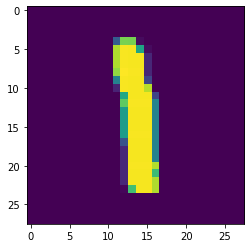

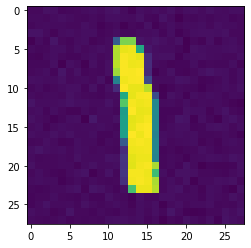

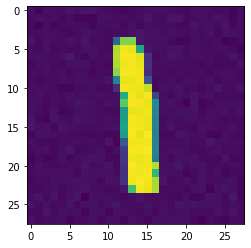

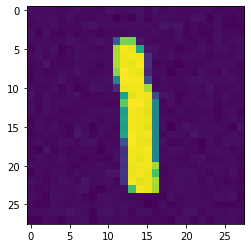

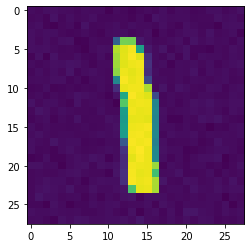

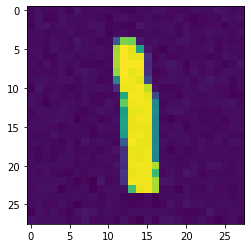

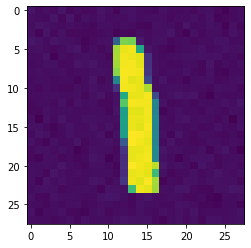

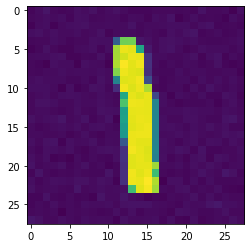

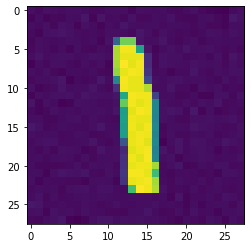

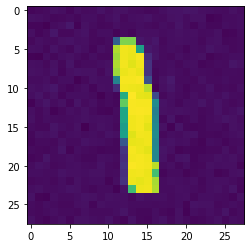

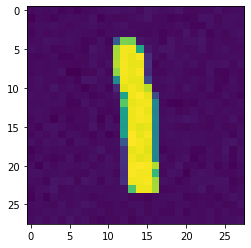

In [12]:
#get a random images and sample in the ball surrounding it
EPSILON = 1
random, _ = next(iter(train_loader))
random = random[0]
#plot original sample
plt.figure()
plt.imshow(random.squeeze())
random_flatten = random.flatten().detach().numpy()
samples = CFI_utils.sampling_inside_ball(10, random.flatten().shape[0], r=EPSILON, origin=random_flatten)
#plot the samples inside the ball
for s in samples:
    #check norm
    print(np.linalg.norm(s-random_flatten))
    plt.figure()
    plt.imshow(s.reshape(28, 28))

In [11]:
#load a model
rq4_model = TinyCNN().to(device)

if LOAD:
    rq4_model.load_state_dict(torch.load(LOADPATH))
    
#get patterns
target_pattern = CFI_utils.get_pattern(model, device, random.unsqueeze(0))
layers = ['conv1', 'conv2', 'fc1', 'fc2']

print()
for idx, s in enumerate(samples):
    print("Sample {}".format(idx))
    s_pattern = CFI_utils.get_pattern(model, device, torch.Tensor(s).reshape(28,28).unsqueeze(0).unsqueeze(0))
    for layer in layers:
        s_pattern_flatten = np.concatenate([s_pattern[l] for l in [layer]], axis = 1)
        target_pattern_flatten = np.concatenate([target_pattern[l] for l in [layer]], axis = 1)
        print("vs target:", layer, CFI_utils.bit_diff(s_pattern_flatten, target_pattern_flatten), "/", 
              len(s_pattern_flatten[0]), CFI_utils.bit_diff(s_pattern_flatten, target_pattern_flatten)/len(s_pattern_flatten[0]))



Sample 0
vs target: conv1 401 / 2704 0.14829881656804733
vs target: conv2 553 / 4608 0.12000868055555555
vs target: fc1 1 / 16 0.0625
vs target: fc2 0 / 10 0.0
Sample 1
vs target: conv1 437 / 2704 0.16161242603550297
vs target: conv2 516 / 4608 0.11197916666666667
vs target: fc1 4 / 16 0.25
vs target: fc2 0 / 10 0.0
Sample 2
vs target: conv1 425 / 2704 0.15717455621301776
vs target: conv2 520 / 4608 0.11284722222222222
vs target: fc1 1 / 16 0.0625
vs target: fc2 0 / 10 0.0
Sample 3
vs target: conv1 434 / 2704 0.16050295857988164
vs target: conv2 545 / 4608 0.11827256944444445
vs target: fc1 2 / 16 0.125
vs target: fc2 0 / 10 0.0
Sample 4
vs target: conv1 421 / 2704 0.15569526627218935
vs target: conv2 527 / 4608 0.11436631944444445
vs target: fc1 1 / 16 0.0625
vs target: fc2 0 / 10 0.0
Sample 5
vs target: conv1 430 / 2704 0.15902366863905326
vs target: conv2 523 / 4608 0.1134982638888889
vs target: fc1 1 / 16 0.0625
vs target: fc2 0 / 10 0.0
Sample 6
vs target: conv1 419 / 2704 0.1549